# Pay of Police Department

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

In [3]:
salaries = pd.read_csv('Salaries.csv')
salaries.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


In [4]:
salaries.drop('Notes', axis=1, inplace=True)

In [5]:
salaries['BasePay'] = pd.to_numeric(salaries['BasePay'], errors='coerce')

In [6]:
salaries['OvertimePay'] = pd.to_numeric(salaries['OvertimePay'], errors='coerce')

In [7]:
salaries['OtherPay'] = pd.to_numeric(salaries['OtherPay'], errors='coerce')

In [8]:
salaries['Benefits'] = pd.to_numeric(salaries['Benefits'], errors='coerce')

In [9]:
salaries['Status'] = salaries['Status'].apply(lambda x: x if type(x) == str else None)

In [10]:
salaries['Status'].value_counts()

FT    22334
PT    15785
Name: Status, dtype: int64

In [11]:
salaries.drop('Agency', axis=1, inplace=True)

In [12]:
years = salaries.loc[salaries['JobTitle'].str.contains('Police', case=False), 'Year'].unique()

In [13]:
salaries['JobTitle'] = salaries['JobTitle'].apply(lambda x: x.lower())
salaries['JobTitle'] = salaries['JobTitle'].apply(lambda x: re.sub(r'\b3\b', 'iii', x))
salaries['JobTitle'] = salaries['JobTitle'].apply(lambda x: re.sub(r'\b2\b', 'ii', x))
salaries['JobTitle'] = salaries['JobTitle'].apply(lambda x: re.sub(r'\b1\b', 'i', x))

In [14]:
police_titles = salaries.loc[salaries['JobTitle'].str.contains('Police', case=False), 'JobTitle'].unique()

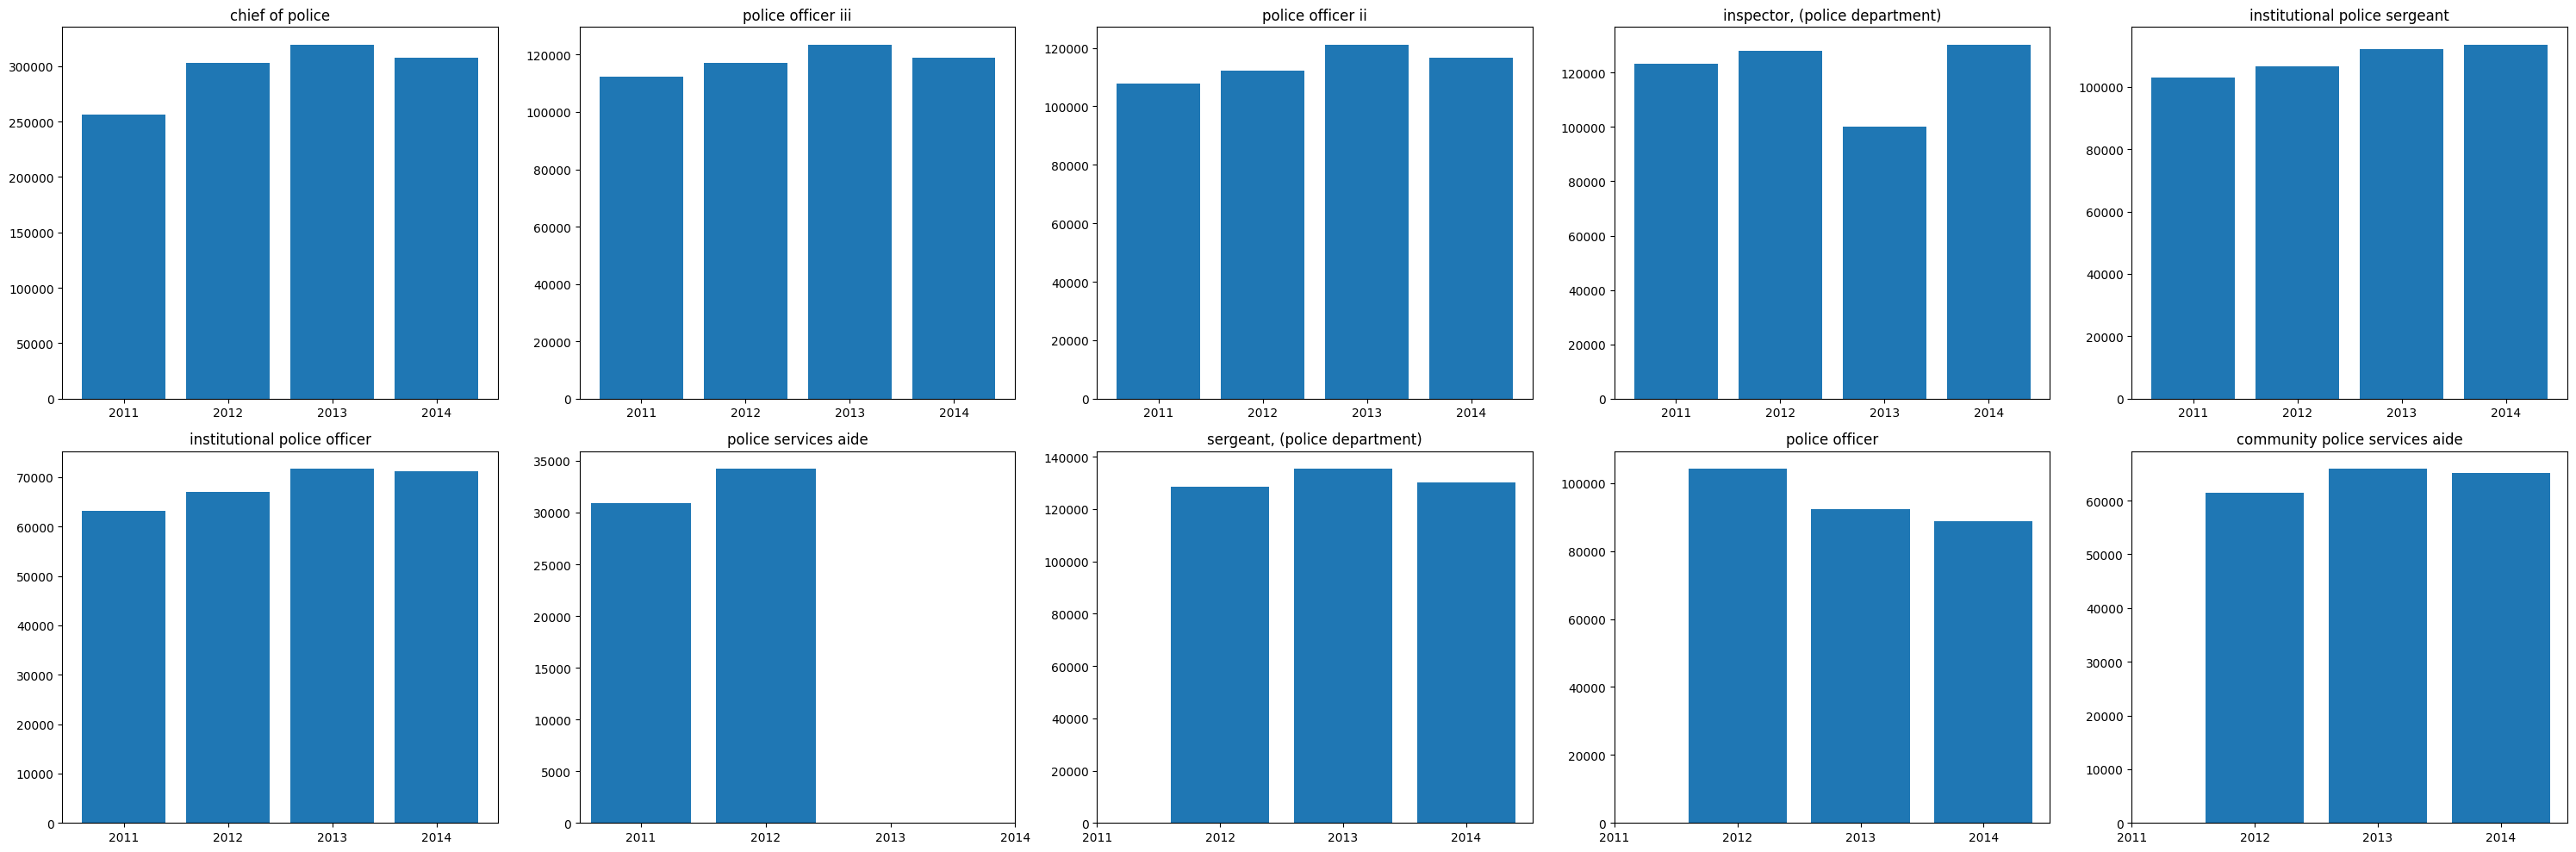

In [15]:
grouped = salaries.groupby(['JobTitle', 'Year'])['BasePay'].median()
police_titles_mult = [title for title in police_titles if len(grouped[title].index)>1]
num_titles = len(police_titles_mult)

fig, ax = plt.subplots(math.ceil(num_titles/5),5, figsize=(30,10))
for i, title in enumerate(police_titles_mult):
    ax_flat = ax.flatten()
    ax_flat[i].bar(grouped[title].index, grouped[title].values)
    ax_flat[i].set_xticks([2011, 2012, 2013, 2014])
    ax_flat[i].set_title(title)
plt.tight_layout() 
plt.show()

We see that the salaries of chief of police, institutional police sergeant, police officer ii, and instutitional police officer have all risen from 2011 to 2013, with all but the institutional police sergeant seeing a reduction in base pay in 2014.

## Gender Analysis

In [16]:
import gender_guesser.detector as gender
d = gender.Detector()

In [17]:
salaries['Gender'] = salaries['EmployeeName'].apply(lambda x: d.get_gender(x.split(' ')[0].lower().capitalize()))
salaries['Gender'] = salaries['Gender'].replace({'mostly_female':'female', 'mostly_male':'male', 'andy':None, 'unknown':None})

In [18]:
salaries['Gender'].value_counts()

male      73155
female    55033
Name: Gender, dtype: int64

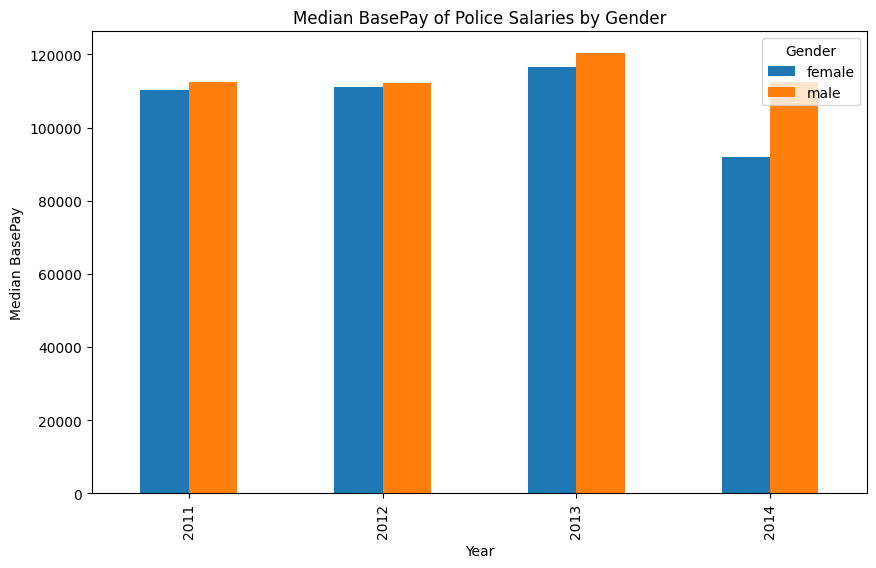

In [19]:
police_salaries = salaries[salaries['JobTitle'].str.contains('police')]
gender_salary_police = police_salaries.groupby(['Year', 'Gender'])['BasePay'].median()

gender_salary_police_df = gender_salary_police.unstack()

ax = gender_salary_police_df.plot(kind='bar', figsize=(10, 6))

ax.set_xlabel('Year')
ax.set_ylabel('Median BasePay')
ax.set_title('Median BasePay of Police Salaries by Gender')

plt.show()

We see that men in police department have been paid more consistently every year from 2011 to 2014.

In [20]:
police_salaries_copy = police_salaries.copy().drop(['Id','EmployeeName','OvertimePay','OtherPay','Benefits','TotalPay','TotalPayBenefits'], axis=1)
job_title_counts = police_salaries_copy['JobTitle'].value_counts()
filtered_df = police_salaries_copy[police_salaries_copy['JobTitle'].isin(job_title_counts.index[job_title_counts > 100])]
filtered_df['JobTitle'].value_counts()

police officer iii                    3200
police officer ii                     1502
police officer                        1476
community police services aide         559
police officer i                       467
sergeant iii (police department)       295
airport police services aide           187
inspector iii, (police department)     162
Name: JobTitle, dtype: int64

In [21]:
filtered_df['Status']

33        None
37        None
74        None
75        None
111       None
          ... 
148312      PT
148409      PT
148437      PT
148506      PT
148561      PT
Name: Status, Length: 7848, dtype: object

In [22]:
filtered_df['isMale'] = filtered_df['Gender']
filtered_df['isMale'] = filtered_df['Gender'].apply(lambda x: 1 if x == 'male' else (0 if x == 'female' else -1))
filtered_df.drop('Gender',axis=1, inplace=True)
filtered_df['FullTime'] = filtered_df['Status'].replace({'PT':0, 'FT':1, np.nan:-1})
filtered_df.drop('Status', axis=1, inplace=True)

In [23]:
job_titles = filtered_df['JobTitle'].unique()
job_map = {}
for i, title in enumerate(job_titles):
    job_map[title] = i
    
filtered_df['JobTitle'] = filtered_df['JobTitle'].apply(lambda x: job_map[x])
filtered_df

,JobTitle,BasePay,Year,isMale,FullTime
33,0,104861.39,2011,1,-1.0
37,0,110661.20,2011,1,-1.0
74,0,130457.88,2011,1,-1.0
75,0,85578.61,2011,1,-1.0
111,1,63811.18,2011,-1,-1.0
...,...,...,...,...,...
148312,6,309.90,2014,1,0.0
148409,6,0.00,2014,1,0.0
148437,1,0.00,2014,0,0.0
148506,7,0.00,2014,0,0.0


In [24]:
filtered_df = filtered_df.dropna(subset = ['BasePay'])
X = filtered_df.drop('BasePay', axis=1)
y = filtered_df['BasePay']

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':np.linspace(100,300,5, dtype=int), 'n_jobs':[-1]}
model = RandomForestRegressor()

grid = GridSearchCV(model, param_grid)
grid.fit(X,y)
best_params = grid.best_params_
model = RandomForestRegressor(**best_params, random_state=42)

In [26]:
best_params

{'n_estimators': 250, 'n_jobs': -1}

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
features = ['JobTitle','isMale','Year','FullTime']
model.fit(X_train[features], y_train)
model.score(X_test[features], y_test)

0.5472817247616075

Our model does not perform well on the test set. As expected, when we exclude job title from the selected features, we see a sharp drop in model performance. Unfortunately, even with the job title included into the model training, we see poor performance. It may just be that the size of the entire dataset of police jobs (~8000 entries) is not enough to accurately train a regression model. Our grid search supports this argument, when changing the range of values for the n_estimators parameter, the grid search consistently chooses minimal values, suggesting that the data does not exhibit strong patterns. It may also be the case that replacing null values in our dataset with -1 could have introduced bias that prevented our model from being able to identify patterns in the data. It may be inappropriate to replace null values in the isMale and FullTime columsn given that both of these features are binary features. In doing so, the -1 may be treated as a distinct category and/or may have increased impact on the model vs in a case where the feature spans a wider range.